# Keyword Graph Analysis

In [ ]:
## From this point on, I will be using the cleaned south region dataset
import pandas as pd 
import numpy as np
import nltk 
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import networkx as nx

In [ ]:
# ## initial nltk download
nltk.download('punkt')
nltk.download('stopwords')

AttributeError: module 'nltk' has no attribute 'internals'

In [ ]:
stemmer = SnowballStemmer(language = "english")
stop_words = set(stopwords.words('english'))
import string
translate_table = dict((ord(char), None) for char in string.punctuation)   
def stem_sentence_gen(sentence: str) -> set:
    try:
        sentence = sentence.translate(translate_table)
        token_words = word_tokenize(sentence)
        stem_sentence = []
        for word in token_words:
            word = word.lower()
            if word not in stop_words and len(word) > 1:
                stem_sentence.append(stemmer.stem(word))
        return set(stem_sentence)
    except:
        print(sentence)

In [ ]:
def move_columns(df, cols_to_move=[], ref_col="", place="After"):
    cols = df.columns.tolist()
    if place == "After":
        seg1 = cols[: list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == "Before":
        seg1 = cols[: list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]

    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    return df[seg1 + seg2 + seg3]

In [ ]:
listings_clean = pd.read_csv("ht/listings_cleaned.csv")
listings = pd.read_csv("us_south_listings_multi_label.csv")
listings_clean = listings_clean.iloc[:, 1:]
listings_clean["id"] = listings["id"]
listings_clean["name"] = listings["name"]
listings_clean["state"] = listings["state"]

In [ ]:
listings_clean = move_columns(listings_clean, ["id", "state", "name"], "accommodates", )

In [ ]:
listings_tx = listings_clean[listings_clean["state"] == "TX"]

In [ ]:
listings_tx = listings_tx.loc[~listings_tx.isnull().T.any(), :]

In [ ]:
for col in listings_tx.columns:
    if len(listings_tx[col].unique()) == 1:
        listings_tx.drop(col, inplace = True, axis = 1)

In [ ]:
listings_tx["keyword_set"] = listings_tx.name.map(stem_sentence_gen)
word_counter = Counter([j for i in listings_tx["keyword_set"].tolist() for j in list(i)])

In [ ]:
filtered_keyword_count = sorted(list(filter(lambda pair: pair[1] > 4 and not pair[0].isnumeric(), word_counter.items())), key = lambda x: x[1], reverse = True)

In [ ]:
## Move on to generate graph of these listings
graph_df = listings_tx[["keyword_set"]]
for pair in filtered_keyword_count:
    keyword = pair[0]
    graph_df[keyword] = graph_df["keyword_set"].map(lambda keyword_set: 1 if keyword in keyword_set else 0)
graph_df = graph_df.iloc[:, 1:]

ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# graph_df["rating_label"] = listings.rating_label

In [ ]:
# graph_df.to_csv("incident_df_listings_tx.csv", index = False)

In [ ]:
graph_df = pd.read_csv("incident_df_listings.csv")

In [ ]:
inc_mat = graph_df.values

In [ ]:
non_training_columns = {'id', 'name', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'keyword_set'}

In [ ]:
import pickle

In [ ]:
# am = np.dot(inc_mat, inc_mat.T)
# pickle.dump(am, open("adj_mat_tx.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
am = pickle.load(open("adj_mat.p", "rb"))

In [ ]:
# G = nx.from_numpy_array(am)
# pickle.dump(G, open("listing_graph.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
G = pickle.load(open("listing_graph.p", "rb"))

In [ ]:
def rating_map(x):
    return -np.log((100.1/x) - 1)

In [ ]:
def inverse_rating_map(x):
     return 100.1 / (1 + np.exp(-x))

In [ ]:
X = listings_tx[list(set(listings_tx.columns).difference(non_training_columns))]
y = rating_map(listings_tx['review_scores_rating'].values)

In [ ]:
df_clean = listings_tx[list(set(listings_tx.columns).difference(non_training_columns))]

In [ ]:
df_clean = move_columns(df_clean, ["review_scores_rating"], "availability_30")

In [ ]:
df_clean.to_csv("tx_clean_listing_data.csv", index = False)

## GCN Modeling

In [ ]:
import numpy as np
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import ChebConv, GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Parameters
channels = 32           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-4    # Learning rate

# Preprocessing operations
A = GCNConv.preprocess(am).astype("f4")

N, F = X.shape

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(1, use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_absolute_error')
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 51)]         0                                            
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 51)           0           input_25[0][0]                   
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 5942)]       0                                            
__________________________________________________________________________________________________
gcn_conv_23 (GCNConv)           (None, 32)           1632        dropout_26[0][0]                 
                                                                 input_26[0][0]            

In [ ]:
def val_test_idx_gen(y_vals, val_pct = 0.2, test_pct = 0.2):
    '''
    Get the index of train, validation, and test data
    '''
    idx_range = list(range(len(y_vals)))
    s1 = int((len(y_vals) * (1 - val_pct - test_pct)))
    s2 = int((len(y_vals) * (1 - test_pct)))
    train_idx = idx_range[:s1]
    val_idx = idx_range[s1:s2]
    test_idx = idx_range[s2:]
    return train_idx, val_idx,test_idx

In [ ]:
train_idx, val_idx, test_idx = val_test_idx_gen(y)

In [ ]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [ ]:
# labels_encoded = labels_encoded.astype(int)

In [ ]:
validation_data = ([X, A], y, val_mask)
model.fit([X, A],
          y,
          sample_weight=train_mask,
          epochs=200,
          batch_size=N,
          validation_data=validation_data,
          shuffle=True,
          callbacks=[
              EarlyStopping(patience=20,  restore_best_weights=True),
              tbCallBack_GCN
          ])

C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
1/1 [==============================] - 1s 966ms/step - loss: 4.5074 - val_loss: 1.4241


C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 2/200
1/1 [==============================] - 0s 258ms/step - loss: 4.3397 - val_loss: 1.4071
Epoch 3/200
1/1 [==============================] - 0s 188ms/step - loss: 4.3651 - val_loss: 1.3901
Epoch 4/200
1/1 [==============================] - 0s 215ms/step - loss: 4.4158 - val_loss: 1.3732
Epoch 5/200
1/1 [==============================] - 0s 224ms/step - loss: 4.1680 - val_loss: 1.3562
Epoch 6/200
1/1 [==============================] - 0s 219ms/step - loss: 4.1841 - val_loss: 1.3393
Epoch 7/200
1/1 [==============================] - 0s 219ms/step - loss: 4.0623 - val_loss: 1.3225
Epoch 8/200
1/1 [==============================] - 0s 215ms/step - loss: 4.1673 - val_loss: 1.3057
Epoch 9/200
1/1 [==============================] - 0s 230ms/step - loss: 4.0697 - val_loss: 1.2891
Epoch 10/200
1/1 [==============================] - 0s 235ms/step - loss: 3.8800 - val_loss: 1.2726
Epoch 11/200
1/1 [==============================] - 0s 226ms/step - loss: 3.8824 - val_loss: 1.2563
Epoch 12

In [ ]:
result = model.predict([X,A], batch_size = N)

C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
y_pred = inverse_rating_map(result[test_mask].reshape(1189)).astype(int)

<AxesSubplot:>

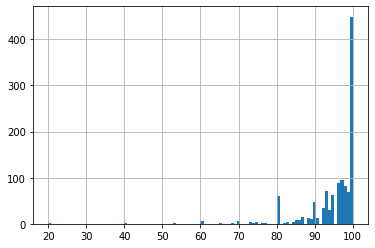

In [ ]:
pd.Series(inverse_rating_map(y[test_mask]).astype(int)).hist(bins = 100)

<AxesSubplot:>

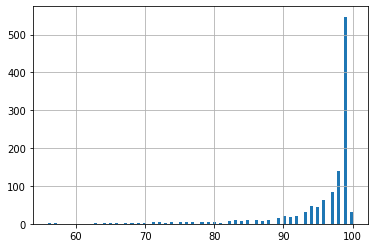

In [ ]:
pd.Series(y_pred.astype(int)).hist(bins = 100)

In [ ]:
np.sqrt(mean_squared_error(y_pred.astype(int), inverse_rating_map(y[test_mask]).astype(int)))

10.162266324718104

In [ ]:
r2_score(inverse_rating_map(y[test_mask]).astype(int), y_pred.astype(int))

-0.8684673785436712

In [ ]:
model.predict([X, A])

TypeError: predict() got an unexpected keyword argument 'sample_weight'

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3])

C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
C:\Users\bzhuo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


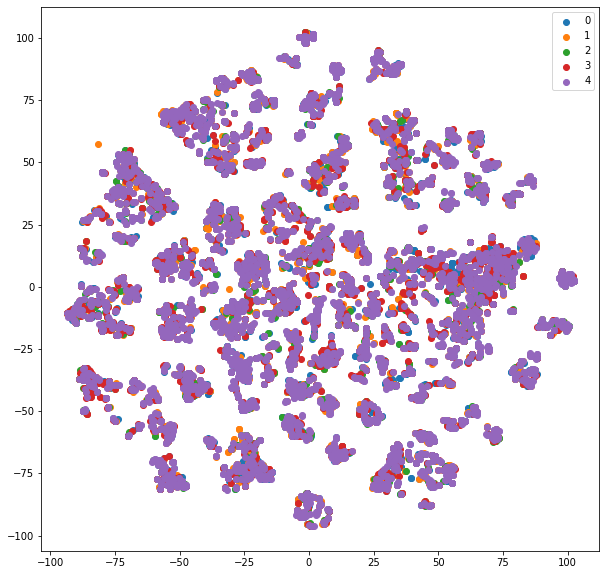

In [ ]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(100):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e6d3dd7-a3ce-422e-8f25-57163d804f84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>